In [64]:
####################################################
#                  BE CAREFULL                     #
#                 DO NOT TRAIN                     #
#    DATA ARE NOT AVAILABLE IN THIS REPOSITORY     #
####################################################

training = False
save_model = False

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torchvision
from torchvision import transforms

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader

from PIL import Image


In [66]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Data Preparation

In [67]:
class MyCropFunction:
    def __init__(self, height, width):
        self.height = height
        self.width = width
        
    def __call__(self, x):
        return transforms.functional.crop(x, 0, 0, self.height, self.width)

transform = torchvision.transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.Grayscale(),
    MyCropFunction(height=83, width=83),
    transforms.ToTensor(),
])

In [68]:
train_images = torchvision.datasets.ImageFolder(root="images/train", transform=transform)
test_images = torchvision.datasets.ImageFolder(root="images/test", transform=transform)

In [69]:
BATCH_SIZE = 64

In [70]:
train_loader = DataLoader(
    train_images, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_images, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

(1, 83, 83)


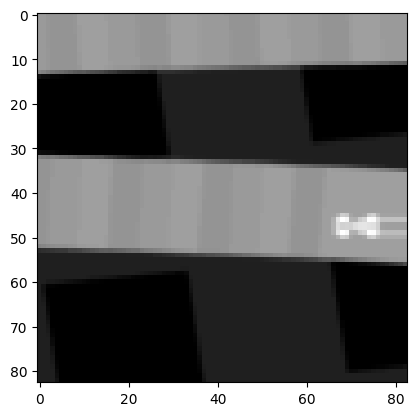

In [71]:
image = train_loader.dataset[55][0].numpy()
print(image.shape)
plt.imshow(image[0], cmap="Greys")

In [72]:
def dim_encoder(Hin, Win, padding, dilation, kernel_size, stride):
    Hout = (Hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1
    Wout = (Win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1
    return math.floor(Hout), math.floor(Wout)

Hin, Win = 83, 83
Hout, Wout = dim_encoder(Hin, Win, padding=(1, 1), dilation=(1, 1), kernel_size=(3, 3), stride=(2, 2))
Hout, Wout = dim_encoder(Hout, Wout, (1, 1), (1, 1), (3, 3), (2, 2))
Hout, Wout = dim_encoder(Hout, Wout, (0, 0), (1, 1), (3, 3), (2, 2))

print(Hout, Wout)


10 10


# Classic AutoEncoder

*Credit to https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac that proposes an autoencoder architecture used in this section and provides function to train, test and plot the results of the networks*

In [73]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten(start_dim=1)
        
        self.encoder_lin = nn.Sequential(
            nn.Linear(10 * 10 * 256, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim),
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        
        return x

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 10 * 10 * 256)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256, 10, 10))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x


In [74]:
if training: 
    ### Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Define an optimizer (both for the encoder and the decoder!)
    lr= 0.001

    ### Initialize the two networks
    d = 20

    #model = Autoencoder(encoded_space_dim=encoded_space_dim)
    encoder = Encoder(encoded_space_dim=d)
    decoder = Decoder(encoded_space_dim=d)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]

    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

    # Check if the GPU is available
    print(f'Selected device: {device}')

    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)
    
else:
    d = 20
    
    encoder = Encoder(encoded_space_dim=d)
    encoder.load_state_dict(torch.load("models/encoder"))
    
    decoder = Decoder(encoded_space_dim=d)
    decoder.load_state_dict(torch.load("models/decoder"))
    
    encoder.to(device)
    decoder.to(device)

In [75]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader:
        image_batch = image_batch.to(device)
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [76]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [77]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      index = np.random.randint(0, len(test_images))
      img = test_images[index][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      image = img.cpu().squeeze().numpy()
      image = np.moveaxis(image, 0, -1)
      plt.imshow(image.astype(np.float32))
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      rec_image = rec_img.cpu().squeeze().numpy()
      rec_image = np.moveaxis(rec_image, 0, -1)
      plt.imshow(rec_image.astype(np.float32))  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

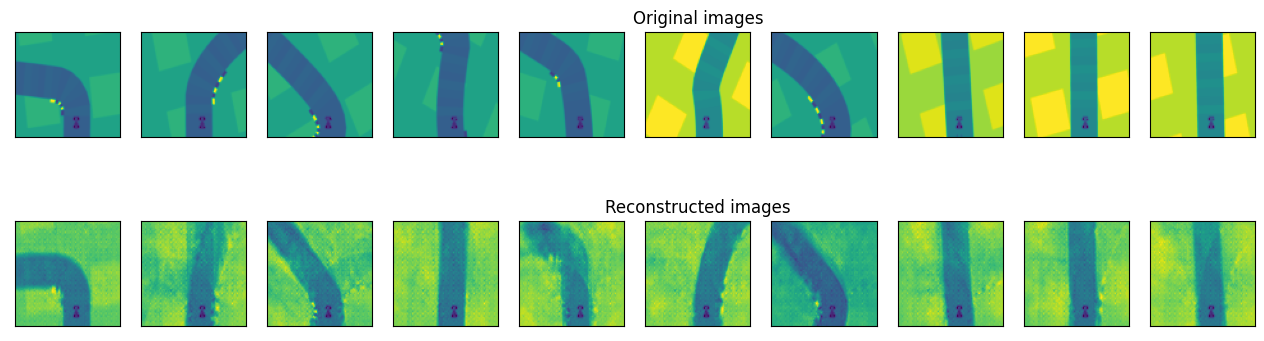

In [78]:
if training:   
   num_epochs = 150
   diz_loss = {'train_loss':[],'val_loss':[]}
   for epoch in range(num_epochs):
      train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
      val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
      print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
      diz_loss['train_loss'].append(train_loss)
      diz_loss['val_loss'].append(val_loss)
      if epoch % 10 == 0:
         plot_ae_outputs(encoder,decoder,n=10)
else:
   plot_ae_outputs(encoder,decoder,n=10)
   

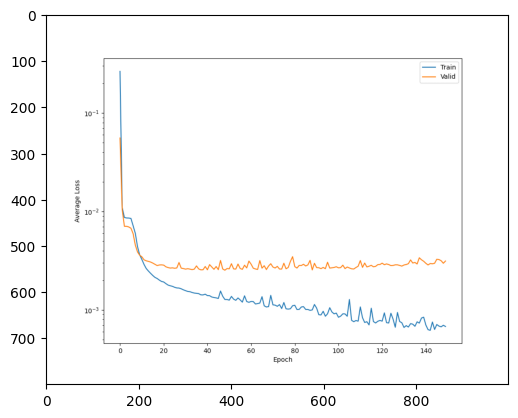

In [79]:
# Plot losses
if training:
    plt.figure(figsize=(10,8))
    plt.semilogy(diz_loss['train_loss'], label='Train')
    plt.semilogy(diz_loss['val_loss'], label='Valid')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.savefig("results/figures/autoencoder_loss_evolution.png")
    plt.show()
else:
    img = np.asarray(Image.open("results/figures/autoencoder_loss_evolution.png"))
    imgplot = plt.imshow(img)
    plt.show()

In [80]:
if save_model:
    torch.save(encoder.state_dict(), "models/encoder")
    torch.save(decoder.state_dict(), "models/decoder")

# Variational AutoEncoder

*Credit to the TP_8 of the course XINF-581 that inspires a variational autoencoder architecture used in this section and provides function to train the networks*

In [81]:
class VAE(nn.Module):
    def __init__(self, z_dim=20):
        super(VAE, self).__init__()
        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Flatten(start_dim=1),
            nn.Linear(10 * 10 * 256, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, z_dim + z_dim)
        )
        
        self.decoder_cnn = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 10 * 10 * 256),
            nn.Unflatten(dim=1, unflattened_size=(256, 10, 10)),
            nn.ConvTranspose2d(256, 128, 3, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1)
        )
        
    def encode(self, x):
        h = self.encoder_cnn(x)
        return torch.tensor_split(h, 2, axis=1)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_cnn(z)
        return torch.sigmoid(h)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [82]:
def plot_vae_outputs(model, n=10):
    plt.figure(figsize=(16,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      index = np.random.randint(0, len(test_images))
      img = test_images[index][0].unsqueeze(0).to(device)
      model.eval()
      with torch.no_grad():
         rec_img  = model(img)[0]
      image = img.cpu().squeeze().numpy()
      image = np.moveaxis(image, 0, -1)
      plt.imshow(image.astype(np.float32))
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      rec_image = rec_img.cpu().squeeze().numpy()
      rec_image = np.moveaxis(rec_image, 0, -1)
      plt.imshow(rec_image.astype(np.float32))  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

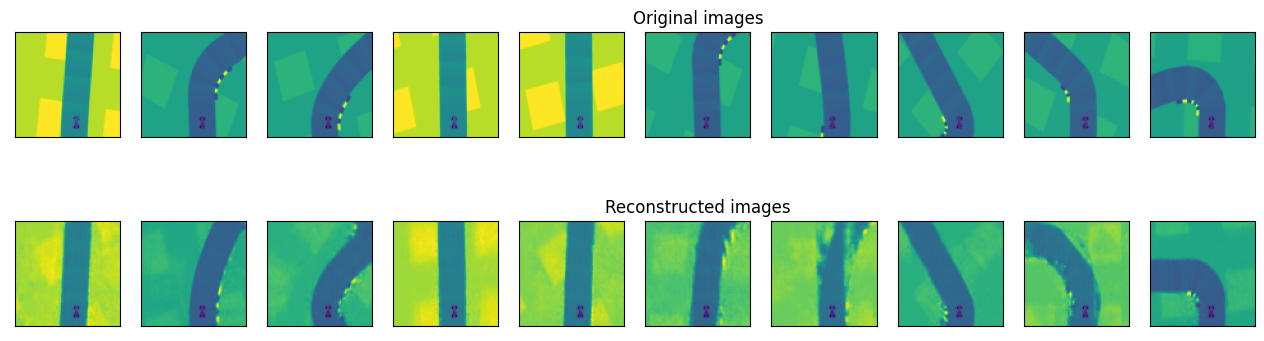

In [83]:
if training:
    image_size = 83 * 83
    num_epochs = 150
    model = VAE().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Start training
    for epoch in range(num_epochs):
        for i, (x, _) in enumerate(train_loader):
            # Forward pass
            x = x.to(device)
            x_reconst, mu, log_var = model(x)
            
            # Compute reconstruction loss and kl divergence
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            
            # Backprop and optimize
            loss = reconst_loss + kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 20 == 0:
                print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                    .format(epoch+1, num_epochs, i+1, len(train_loader), reconst_loss.item()/BATCH_SIZE, kl_div.item()/BATCH_SIZE))
                
        if epoch % 10 == 0:
            plot_vae_outputs(model)
else:
    model = VAE().to(device)
    model.load_state_dict(torch.load("models/vae"))
    plot_vae_outputs(model)
    

In [84]:
if save_model:
    torch.save(model.state_dict(), "models/vae")